In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
import pandas as pd
from scipy.stats import chi2_contingency
import matplotlib.pyplot as plt

spark = SparkSession.builder \
    .appName("OutcomeCorrelation") \
    .getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/09 19:22:53 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
clean_base = "hdfs://localhost:9000/user/yashwanthreddy/crime/clean"
street = spark.read.parquet(f"{clean_base}/street")
outcomes = spark.read.parquet(f"{clean_base}/outcomes")

# Join on crime_id
df = street.join(
    outcomes.select("crime_id", "outcome_type"),
    on="crime_id", how="left"
).select("crime_type", "outcome_type")


In [10]:
#pivot table
# Count occurrences for each (crime_type, outcome_type)
pivot_df = df.groupBy("crime_type","outcome_type") \
             .count() \
             .toPandas()

# Pivot to matrix form
table = pivot_df.pivot(index="crime_type",
                       columns="outcome_type",
                       values="count") \
                .fillna(0)
table.to_csv("output/crime_outcome_crosstab.csv")


25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
25/05/09 19:26:33 WARN TaskMemoryManager: Failed to allocate a page (8388608 bytes), try again.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but

[220.223s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 15.0 (TID 86): Retried waiting for GCLocker too often allocating 1048578 words
[220.226s][warning][gc,alloc] Executor task launch worker for task 1.0 in stage 15.0 (TID 86): Retried waiting for GCLocker too often allocating 1048578 words


25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
25/05/09 19:26:33 WARN RowBasedKeyValueBatch: Calling spill() on

In [12]:
# Chi-square test
chi2, p, dof, expected = chi2_contingency(table.values)
print(f"Chi2={chi2:.2f}, p-value={p:.3g}, dof={dof}")
# Save results
with open("output/chi2_results.txt","w") as f:
    f.write(f"chi2={chi2:.2f}\np={p:.3g}\ndof={dof}\n")


Chi2=8684281.98, p-value=0, dof=156


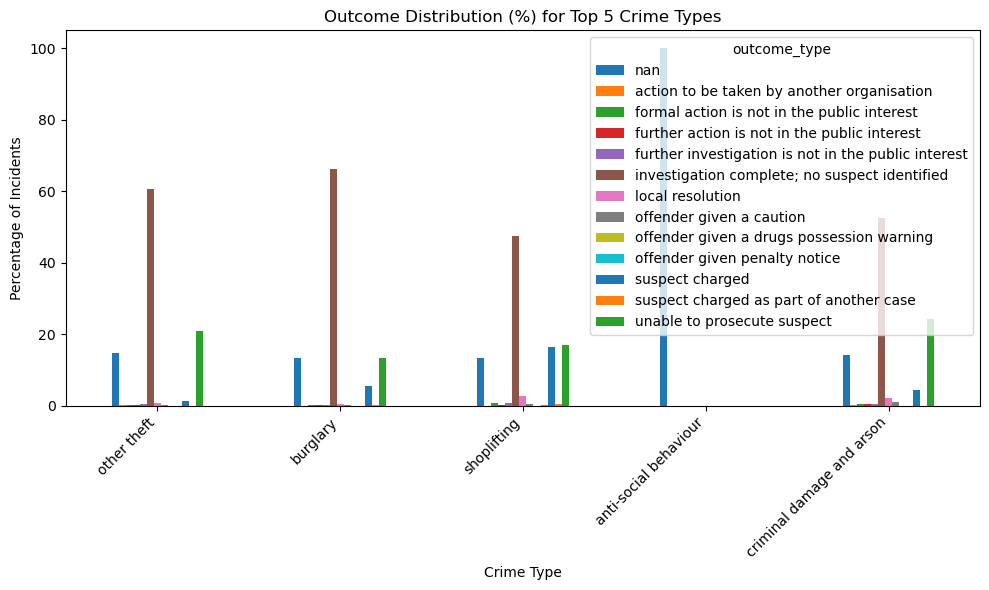

In [14]:
# Grouped bar chart
# Normalize counts to percentages by crime_type
percent = table.div(table.sum(axis=1), axis=0) * 100

# Plot top 5 crime types for clarity
top5 = percent.sum(axis=1).sort_values(ascending=False).head(5).index
plot_df = percent.loc[top5]

plot_df.plot(kind="bar", figsize=(10,6))
plt.title("Outcome Distribution (%) for Top 5 Crime Types")
plt.ylabel("Percentage of Incidents")
plt.xlabel("Crime Type")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.savefig("output/outcome_bar_chart.png")
plt.show()